![](Bilder/MBILogo.png)

# FP O4: Fourier-Transform Holography
## _Simulation part_

This notebook is used for simulating a Fourier-transform holography experiment. The whole (virtual) experiment is executed in the notebook and all documentation, analysis and discussion should be left here. In the end, you can generate a pdf from this notebook and hand it in as experimental report. Use these text boxes and [Markdown formatting](https://de.wikipedia.org/wiki/Markdown) to produce your text. If you prefer, you can change the language of this document to German.

## Important: File saving

The binder session uses a local copy of all data. Once the binder session is terminated or receives a time out, all local data will be _irrevocably lost._ To save your data, open a terminal in the main jupyter window (`new` → `terminal`) and run `./git.sh` or `sh git.sh` using the credientials provided.

## Import Libraries

This needs to be executed once in the beginning when you start the kernel on which the notebook operates. The libaries loaded include functions for numerical operations, scientific plotting and image manipulation.

In [1]:
# NumPy – The fundamental package for scientific computing with Python
# https://numpy.org/
import numpy as np

# Matplotlib – Visualization with Python
# https://matplotlib.org/
import matplotlib.pyplot as plt
#for interactive plots
%matplotlib notebook

## Load the Data

The objects are represented by binary image files. You can concieve this image as the amplitude of the electromagnetic wave in the plane after it has passed an aperture shaped like this image. In this simulation, we consider the phase to be constant (zero) everywhere. 

Please specify the **entire file path and the file name**. Every time you want to analyze a new virtual object, you have to load the image file here and then execute every step. We recomment to either copy the code for each object or to create a new file (`File` → `Make a copy`).

Replace `file` by the following file names for the objects:
1. Sim_1_ohne_Ref.tif
2. Sim_2_eine_Ref.tif
3. Sim_3_multi_Ref.tif
4. Sim_4_multi_Obj.tif

Use the `prefix` to change file names for the output of the notebook.

In [3]:
file = r"Sim_1_ohne_Ref.tif" #The file has to be in the same folder as this script.
your_folder = r'' #The folder where you want to save your data in. Make sure that the folder exists.
prefix = 'Sim_1_ohne_Ref' #This string will be added in front of your saved image. Choose it according to your current simulation.

image = plt.imread(file)

### Plot the object

<IPython.core.display.Javascript object>


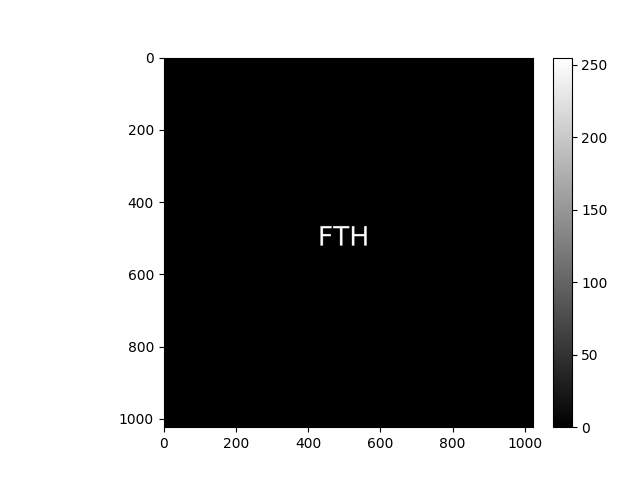

In [8]:
fig, ax = plt.subplots()
ax = plt.imshow(image, cmap = 'gray')
fig.colorbar(ax, fraction=0.046, pad=0.04)

## Fourier Transformation – Propagate to far field

The wave field is propagated into the far field based on the Fraunhofer approximation which states that the far-field diffraction pattern of an object is basically given by the Fourier transformation (FT) of the object. We omit some additional phase terms here (why can we do this?). As our virtual detector only detects intensity, we calculate the magnitude squared of the FT. The numerical fast Fourier transformation function (fft2) expects the center of the coordinate system to be located in pixel (0,0) which is counterintuitive to the typical detector position in the experiment where the beam is centered on the chip, i.e. the center is located at pixel (n/2,n/2). The fftshift function translates between the two representations.

In [58]:
hologram = np.abs(np.fft.fftshift(np.fft.fft2(image)))**2

### Plot the image

Plot the diffraction pattern, i.e. the Fourier transformation with a linear intensity scale (with limits) and as a logarithmic plot.

You can adjust the scale of the linear intensity scale by specifying the minimal (*vmin*) and maximal (*vmax*) displayed value. You can do this with choosing the percentiles in the first line but you can also type in any number you like.

The result is automatically saved as numpy file and as png file. Do not forget to change the `prefix` string in the second code cell to avoid that the file is overwritten.

<IPython.core.display.Javascript object>


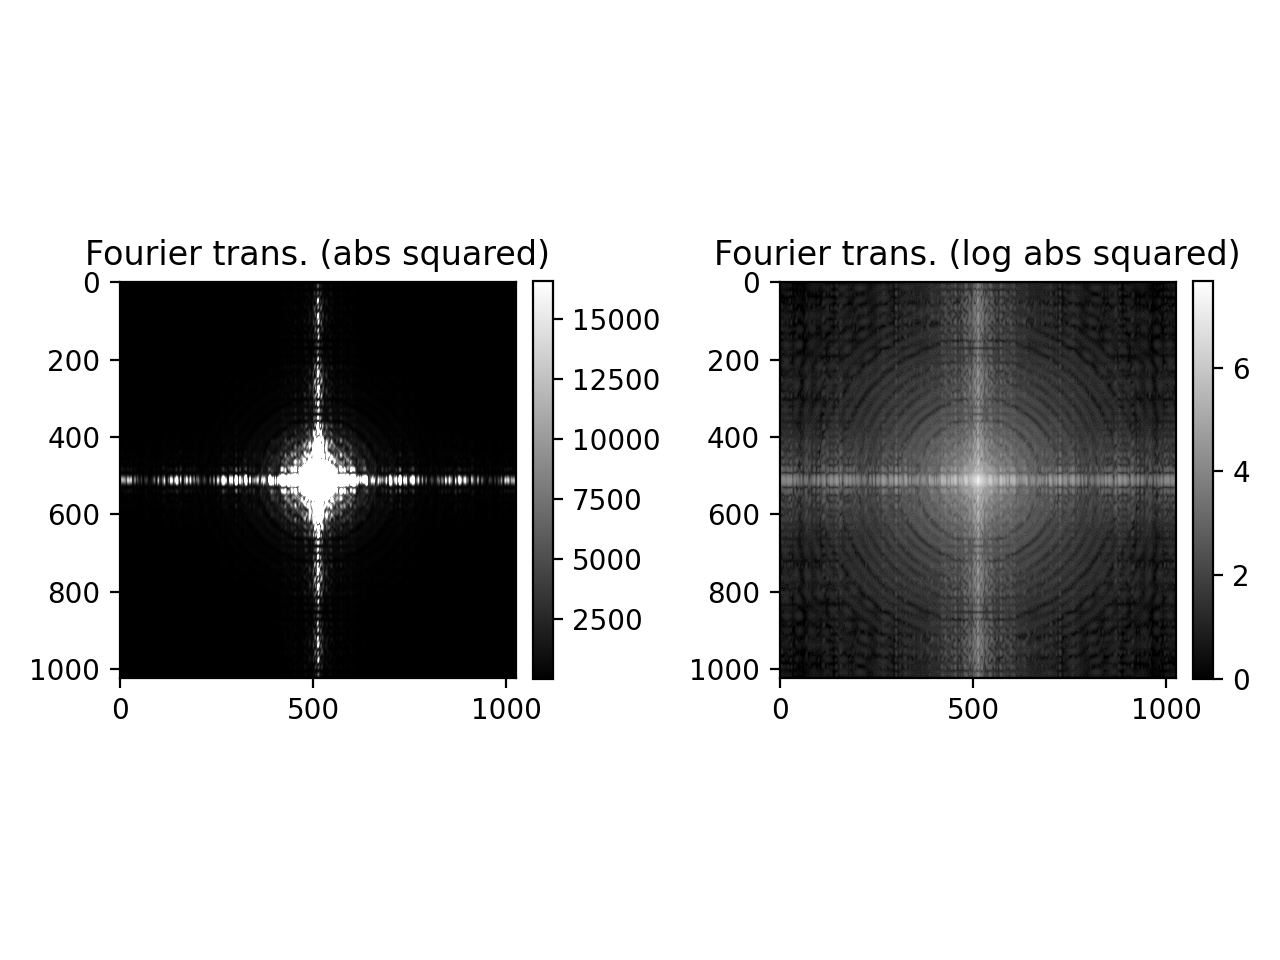

In [59]:
MinV, MaxV = np.percentile(hologram,(2,98))

fig, axs = plt.subplots(1,2)

ax1 = axs[0].imshow(hologram, cmap = 'gray', vmin = MinV, vmax = MaxV)
fig.colorbar(ax1, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title('Fourier trans. (abs squared)')

ax2 = axs[1].imshow(np.log10(hologram), cmap = 'gray', vmin=0)
fig.colorbar(ax2, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title('Fourier trans. (log abs squared)')

fig.tight_layout()

#save image and data
plt.savefig(your_folder + prefix + 'holo.png')
np.save(your_folder + prefix + 'holo', hologram) #saves as numpy array. can be opened in another notebook with np.load('filepath')

## Fourier transformation – Reconstruct

Now the artificial hologram is reconstructed using an inverse Fourier transformation. This is the only step that you will execute with the experimental data.

In [60]:
recon = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(hologram))))

### Plot the image

As before...

<IPython.core.display.Javascript object>


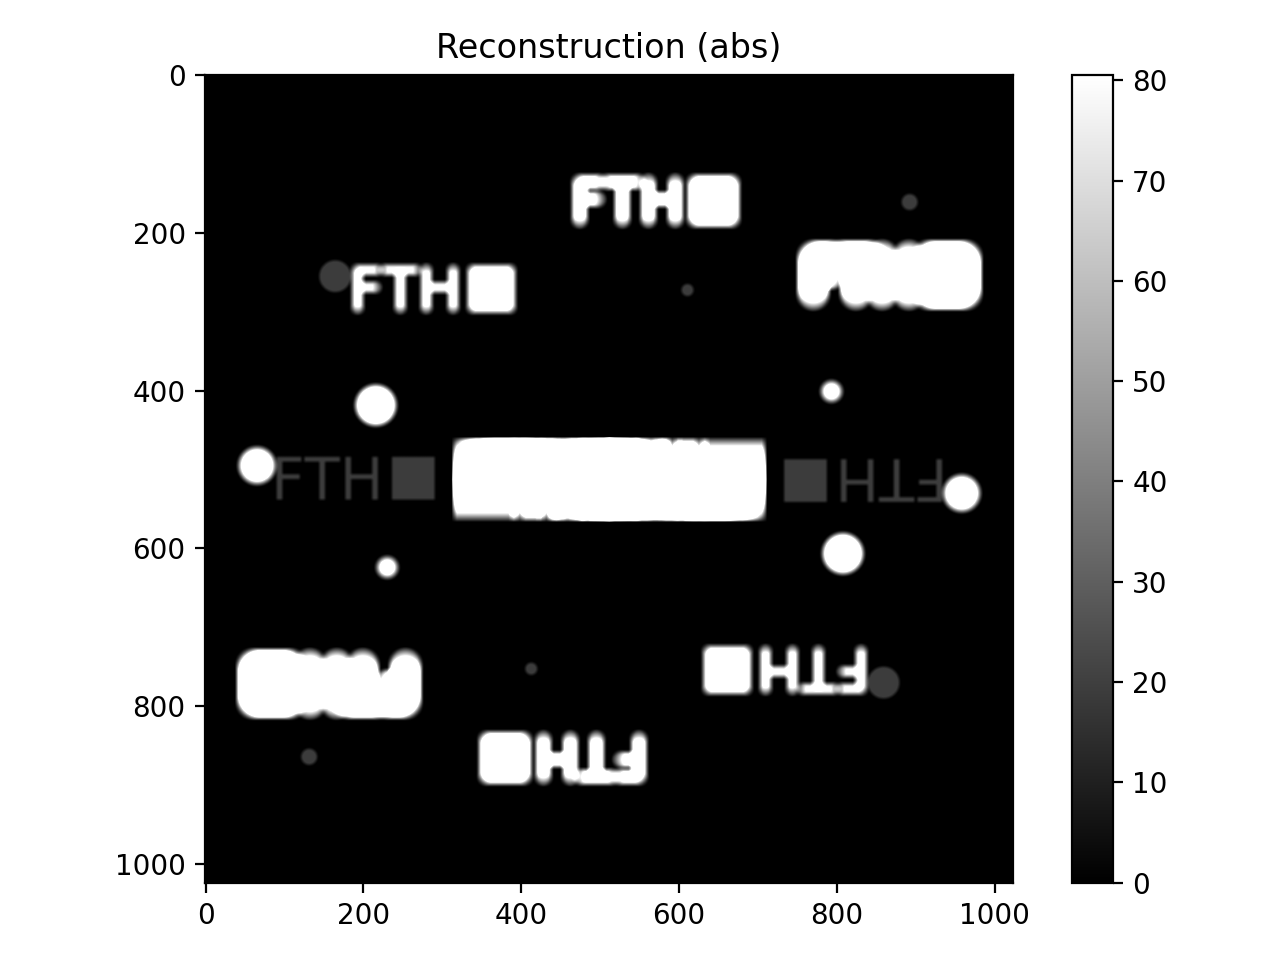

In [63]:
MinV, MaxV = np.percentile(recon,(3,90))

fig, ax = plt.subplots()

ax = plt.imshow(recon, cmap = 'gray', vmin = MinV, vmax = MaxV)
plt.colorbar()
plt.title('Reconstruction (abs)')

fig.tight_layout()

#save image and data
plt.savefig(your_folder + prefix + 'recon.png')
np.save(your_folder + prefix + 'recon', recon) #saves as numpy array. can be opened in another notebook with np.load('filepath')

## Tasks

### Objects 1 and 2
* Describe the function of FTH using the first two object examples.
* How is the image created in FTH?
* Why do we observe two images?
* Where is the image located in the reconstruction matrix?
* What determines its resolution and its brightness?

### Object 3
* Compare and explain the different images with respect to their resolution and intensity.
* Use the Square object and the `lineout` function (below) to quantify your results. 

### Object 4
* Explain the multitude of images appearing in the reconstruction matrix. 
* Download the object and reconstruction images (you'll find a png in your folder) and use some kind of color coding to mark the referecne–object relations.
* Upload your modified images to the notebook afterwards. (You can do this in the main window and display the image here using markdown code. You can find an example on how to include an image in the first MArkdowncell of this notebook).

### Lineout

Do reasonable intensity lineouts to determine the resolution and intensity using the 10%–90% criterion.

You can determine the pixel positions by using the cursor over your image. You can also select an area of the image to enlarge it by using the butten left of the floppy disc.

In [ ]:
def lineout(image, startX, endX, startY, endY, file_prefix):
    lineout = np.sum(image[startY:endY, startX:endX], 0)
    
    #plot the lineout
    fig, ax = plt.subplots()
    ax = plt.plot(lineout)
    plt.title("Lineout for resultion")
    plt.xlabel("Pixel")
    plt.ylabel("Intensity [a.u.]")
    
    #save the lineout
    np.savetxt(your_folder + file_prefix + 'lineout.txt', lineout)
    return

In [ ]:
lineout(image=recon, startX = 380, endX = 490, startY = 398, endY = 399, file_prefix=prefix)

If you want to load an existing txt-file of a lineout, you can do this here

In [ ]:
line = np.fromfile(your_folder + 'Sim_3_lineout3.txt', dtype=np.float, sep='\n')

In [ ]:
fig, ax = plt.subplots()
ax.plot(line)